In [1]:
import numpy
import torch
import torch.nn as nn
from collections import OrderedDict
import os
import sys
import warnings
from torch.utils.data import DataLoader
import argparse
import time
import copy
import math
import torchvision.utils as vision_utils
import json
import numpy as np
from torch.distributions import bernoulli
from scipy import linalg
import torchvision.datasets as _datasets
import torchvision.transforms as _transforms
import matplotlib.pyplot as plt
import shutil
import torch.nn.functional as F
from data import Binarize, Smooth, load_mnist, get_sampler
from evals import compute_mu_sigma_pretrained_model, calculate_frechet_distance, _calculate_metrics, get_metrics
from losses import get_disciminator_loss, get_generator_loss
from model import DiscriminatorCNN28, GeneratorCNN28, MLP_mnist, pretrained_mnist_model
from trainer import train
from updates import Lookahead, update_avg_gen, update_ema_gen
from utils import save_models, get_plot_func, get_num_params

In [2]:
a = 1

In [3]:
_NOISE_DIM = 8
_H_FILTERS = 4

In [4]:
G = GeneratorCNN28(noise_dim=_NOISE_DIM, h_filters=_H_FILTERS, out_tanh=True)
D = DiscriminatorCNN28(h_filters=_H_FILTERS, spectral_norm=False, img_size=28)

In [5]:
get_num_params(G)

12672

In [6]:
get_num_params(D)

2768

In [7]:
args = dict(iterations = 100000,
            batch_size = 128,
            lrD = 0.001,
            lrG = 0.001,
            beta1 = 0.05,
            extragrad = False,
            eval_every = 5000,
            lookahead = False,
            eval_avg = False,
            lookahead_k = 1000,
            n_workers = 5,
            device = 'cuda',
            grad_max_norm = None)

In [8]:
batch_size = args['batch_size']
device = args['device']
x = torch.randn(batch_size, _NOISE_DIM, device=device)

In [67]:
def function_creator(G,D, x, func_type="gen"):
    lbl_real = torch.ones(batch_size, 1, device=device)
    lbl_fake = torch.zeros(batch_size, 1, device=device)
    if func_type == "dis2":
        D_shape = []
        for param in D.parameters():
            D_shape.append(list(param.shape))
        def dis_forward2(a, b, c, d, e, f, g, h):
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            dis = [e.view(D_shape[0]), f.view(D_shape[1]), g.view(D_shape[2]), h.view(D_shape[3])]
            x = x.view(-1, 1, 28, 28)
            x = F.conv2d(x, dis[0], bias=None, stride=2, padding=1)
            x = F.leaky_relu(x, negative_slope=0.2, inplace=True)
            x = F.conv2d(x, dis[1], bias=None, stride=2, padding=1)
            x = F.batch_norm(x, running_mean=None, running_var=None, weight=None, bias=None, training=True, momentum=0.1, eps=1e-05)
            x = F.leaky_relu(x, negative_slope=0.2, inplace=True)
            x = F.conv2d(x, dis[2], bias=None, stride=2, padding=1)
            x = F.batch_norm(x, running_mean=None, running_var=None, weight=None, bias=None, training=True, momentum=0.1, eps=1e-05)
            x = F.leaky_relu(x, negative_slope=0.2, inplace=True)
            D_x= F.conv2d(x, dis[3], bias=None, stride=1, padding=0)
            D_x = D_x.view(-1, 1)
            loss = torch.binary_cross_entropy_with_logits(D_x, lbl_real).mean()
            return loss
        return dis_forward2
    elif func_type == "gen":
        D_shape = []
        for param in D.parameters():
            D_shape.append(list(param.shape))
        G_shape = []
        for param in G.parameters():
            G_shape.append(list(param.shape))
        def gen_forward(a, b, c, d, e, f, g, h):
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            gen = [a.view(G_shape[0]).to(device), b.view(G_shape[1]).to(device), c.view(G_shape[2]).to(device), d.view(G_shape[3]).to(device)]
            dis = [e.view(D_shape[0]).to(device), f.view(D_shape[1]).to(device), g.view(D_shape[2]).to(device), h.view(D_shape[3]).to(device)]
            x = torch.randn(batch_size, _NOISE_DIM, device=device)
            x = x.view(-1, _NOISE_DIM, 1, 1)
            x = F.conv_transpose2d(x, gen[0], bias=None, stride=1, padding=0)
            x = F.batch_norm(x, running_mean=None, running_var=None, weight=None, bias=None, training=True, momentum=0.1, eps=1e-05)
            x = F.conv_transpose2d(x, gen[1], bias=None, stride=2, padding=1)
            x = F.batch_norm(x, running_mean=None, running_var=None, weight=None, bias=None, training=True, momentum=0.1, eps=1e-05)
            x = F.conv_transpose2d(x, gen[2], bias=None, stride=2, padding=0)
            x = F.batch_norm(x, running_mean=None, running_var=None, weight=None, bias=None, training=True, momentum=0.1, eps=1e-05)
            x = F.conv_transpose2d(x, gen[3], bias=None, stride=2, padding=1)
            x = F.tanh(x)
            
            x = x.view(-1, 1, 28, 28)
            x = F.conv2d(x, dis[0], bias=None, stride=2, padding=1)
            x = F.leaky_relu(x, negative_slope=0.2, inplace=True)
            x = F.conv2d(x, dis[1], bias=None, stride=2, padding=1)
            x = F.batch_norm(x, running_mean=None, running_var=None, weight=None, bias=None, training=True, momentum=0.1, eps=1e-05)
            x = F.leaky_relu(x, negative_slope=0.2, inplace=True)
            x = F.conv2d(x, dis[2], bias=None, stride=2, padding=1)
            x = F.batch_norm(x, running_mean=None, running_var=None, weight=None, bias=None, training=True, momentum=0.1, eps=1e-05)
            x = F.leaky_relu(x, negative_slope=0.2, inplace=True)
            D_G_x = F.conv2d(x, dis[3], bias=None, stride=1, padding=0)
            D_G_x = D_G_x.view(-1, 1)
            loss = torch.binary_cross_entropy_with_logits(D_G_x, lbl_real).mean()
            return loss
        return gen_forward
    elif func_type == "dis1":
        D_shape = []
        for param in D.parameters():
            D_shape.append(list(param.shape))
        G_shape = []
        for param in G.parameters():
            G_shape.append(list(param.shape))
        def dis_forward1(a, b, c, d, e, f, g, h):
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            gen = [a.view(G_shape[0]), b.view(G_shape[1]), c.view(G_shape[2]), d.view(G_shape[3])]
            dis = [e.view(D_shape[0]), f.view(D_shape[1]), g.view(D_shape[2]), h.view(D_shape[3])]
            x = x.view(-1, _NOISE_DIM, 1, 1)
            x = F.conv_transpose2d(x, gen[0], bias=None, stride=1, padding=0)
            x = F.batch_norm(x, running_mean=None, running_var=None, weight=None, bias=None, training=False, momentum=0.1, eps=1e-05)
            x = F.conv_transpose2d(x, gen[1], bias=None, stride=2, padding=1)
            x = F.batch_norm(x, running_mean=None, running_var=None, weight=None, bias=None, training=False, momentum=0.1, eps=1e-05)
            x = F.conv_transpose2d(x, gen[2], bias=None, stride=2, padding=0)
            x = F.batch_norm(x, running_mean=None, running_var=None, weight=None, bias=None, training=False, momentum=0.1, eps=1e-05)
            x = F.conv_transpose2d(x, gen[3], bias=None, stride=2, padding=1)
            x = F.tanh(x)
            
            x = x.view(-1, 1, 28, 28)
            x = F.conv2d(x, dis[0], bias=None, stride=2, padding=1)
            x = F.leaky_relu(x, negative_slope=0.2, inplace=True)
            x = F.conv2d(x, dis[1], bias=None, stride=2, padding=1)
            x = F.batch_norm(x, running_mean=None, running_var=None, weight=None, bias=None, training=True, momentum=0.1, eps=1e-05)
            x = F.leaky_relu(x, negative_slope=0.2, inplace=True)
            x = F.conv2d(x, dis[2], bias=None, stride=2, padding=1)
            x = F.batch_norm(x, running_mean=None, running_var=None, weight=None, bias=None, training=True, momentum=0.1, eps=1e-05)
            x = F.leaky_relu(x, negative_slope=0.2, inplace=True)
            D_G_x = F.conv2d(x, dis[3], bias=None, stride=1, padding=0)
            D_G_x = D_G_x.view(-1, 1)
            loss = torch.binary_cross_entropy_with_logits(D_G_x, lbl_fake).mean()
            return loss
        return dis_forward1

In [68]:
g_list = [_.view(-1) for _ in G.parameters()]
print(len(g_list))
d_list = [_.view(-1) for _ in D.parameters()]
print(len(d_list))
params = g_list + d_list
print(len(params))

4
4
8


In [69]:
gen_forward = function_creator(G,D, x,func_type="gen")

In [70]:
h = torch.autograd.functional.hessian(gen_forward, tuple(params))

In [71]:
len(h)

8

In [ ]:
len(h)

In [10]:
lbl_real = torch.ones(batch_size, 1, device=device)
lbl_fake = torch.zeros(batch_size, 1, device=device)
def gen_forward(a, b, c, d, e, f, g, h):
    g = [a.view(16, 64, 3, 3), b.view(64, 32, 4, 4), c.view(32, 16, 4, 4), d.view(16, 1, 4, 4)]
    d = [e.view(8, 1, 4, 4), f.view(16, 8, 4, 4), g.view(32, 16, 4, 4), h.view(1, 32, 3, 3)]
    x = F.conv_transpose2d(x, g[0], bias=None, stride=1, padding=0)
    x = F.batch_norm(x, running_mean=None, running_var=None, weight=None, bias=None, training=False, momentum=0.1, eps=1e-05)
    x = F.conv_transpose2d(x, g[1], bias=None, stride=2, padding=1)
    x = F.batch_norm(x, running_mean=None, running_var=None, weight=None, bias=None, training=False, momentum=0.1, eps=1e-05)
    x = F.conv_transpose2d(x, g[2], bias=None, stride=2, padding=0)
    x = F.batch_norm(x, running_mean=None, running_var=None, weight=None, bias=None, training=False, momentum=0.1, eps=1e-05)
    x = F.conv_transpose2d(x, g[3], bias=None, stride=2, padding=1)
    x = F.tanh(x)
    x = F.conv_transpose2d(x, d[0], bias=None, stride=2, padding=1)
    x = F.leaky_relu(x, negative_slope=0.2, inplace=True)
    x = F.conv_transpose2d(x, d[1], bias=None, stride=2, padding=1)
    x = F.batch_norm(x, running_mean=None, running_var=None, weight=None, bias=None, training=False, momentum=0.1, eps=1e-05)
    x = F.leaky_relu(x, negative_slope=0.2, inplace=True)
    x = F.conv_transpose2d(x, d[2], bias=None, stride=2, padding=1)
    x = F.batch_norm(x, running_mean=None, running_var=None, weight=None, bias=None, training=False, momentum=0.1, eps=1e-05)
    x = F.leaky_relu(x, negative_slope=0.2, inplace=True)
    D_G_x = F.conv_transpose2d(x, d[3], bias=None, stride=1, padding=0)
    D_G_x.view(-1, 1)
    loss = torch.binary_cross_entropy_with_logits(D_G_x, lbl_real).mean()
    return loss
def dis_forward1(a, b, c, d, e, f, g, h):
    g = [a.view(16, 64, 3, 3), b.view(64, 32, 4, 4), c.view(32, 16, 4, 4), d.view(16, 1, 4, 4)]
    d = [e.view(8, 1, 4, 4), f.view(16, 8, 4, 4), g.view(32, 16, 4, 4), h.view(1, 32, 3, 3)]
    x = F.conv_transpose2d(x, g[0], bias=None, stride=1, padding=0)
    x = F.batch_norm(x, running_mean=None, running_var=None, weight=None, bias=None, training=False, momentum=0.1, eps=1e-05)
    x = F.conv_transpose2d(x, g[1], bias=None, stride=2, padding=1)
    x = F.batch_norm(x, running_mean=None, running_var=None, weight=None, bias=None, training=False, momentum=0.1, eps=1e-05)
    x = F.conv_transpose2d(x, g[2], bias=None, stride=2, padding=0)
    x = F.batch_norm(x, running_mean=None, running_var=None, weight=None, bias=None, training=False, momentum=0.1, eps=1e-05)
    x = F.conv_transpose2d(x, g[3], bias=None, stride=2, padding=1)
    x = F.tanh(x)
    x = F.conv_transpose2d(x, d[0], bias=None, stride=2, padding=1)
    x = F.leaky_relu(x, negative_slope=0.2, inplace=True)
    x = F.conv_transpose2d(x, d[1], bias=None, stride=2, padding=1)
    x = F.batch_norm(x, running_mean=None, running_var=None, weight=None, bias=None, training=False, momentum=0.1, eps=1e-05)
    x = F.leaky_relu(x, negative_slope=0.2, inplace=True)
    x = F.conv_transpose2d(x, d[2], bias=None, stride=2, padding=1)
    x = F.batch_norm(x, running_mean=None, running_var=None, weight=None, bias=None, training=False, momentum=0.1, eps=1e-05)
    x = F.leaky_relu(x, negative_slope=0.2, inplace=True)
    D_G_x = F.conv_transpose2d(x, d[3], bias=None, stride=1, padding=0)
    D_G_x.view(-1, 1)
    loss = torch.binary_cross_entropy_with_logits(D_G_x, lbl_fake).mean()
    return loss
def dis_forward2(a, b, c, d, e, f, g, h):
    d = [e.view(8, 1, 4, 4), f.view(16, 8, 4, 4), g.view(32, 16, 4, 4), h.view(1, 32, 3, 3)]
    x = F.conv_transpose2d(x, d[0], bias=None, stride=2, padding=1)
    x = F.leaky_relu(x, negative_slope=0.2, inplace=True)
    x = F.conv_transpose2d(x, d[1], bias=None, stride=2, padding=1)
    x = F.batch_norm(x, running_mean=None, running_var=None, weight=None, bias=None, training=False, momentum=0.1, eps=1e-05)
    x = F.leaky_relu(x, negative_slope=0.2, inplace=True)
    x = F.conv_transpose2d(x, d[2], bias=None, stride=2, padding=1)
    x = F.batch_norm(x, running_mean=None, running_var=None, weight=None, bias=None, training=False, momentum=0.1, eps=1e-05)
    x = F.leaky_relu(x, negative_slope=0.2, inplace=True)
    D_x= F.conv_transpose2d(x, d[3], bias=None, stride=1, padding=0)
    D_x.view(-1, 1)
    loss = torch.binary_cross_entropy_with_logits(D_x, lbl_real).mean()
    return loss

Loading trained model from ./drive/My Drive/Data/models/mnist.pth
Iter 0: Mean proba from D(G(z)): 0.5781 +/- 0.0767


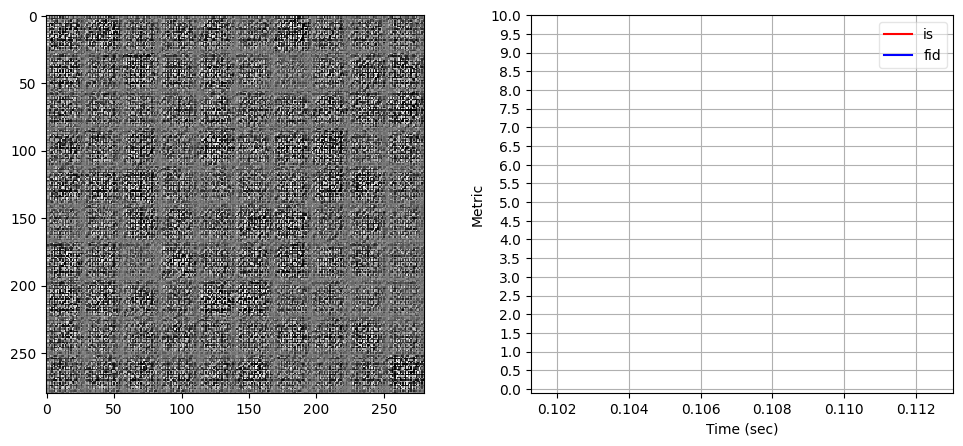

Iter 5000: Mean proba from D(G(z)): 0.4741 +/- 0.1030


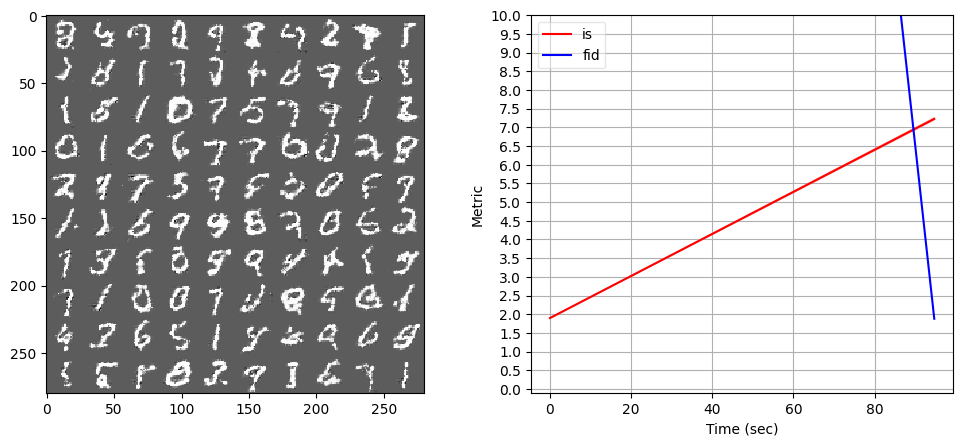

Iter 10000: Mean proba from D(G(z)): 0.4312 +/- 0.0874


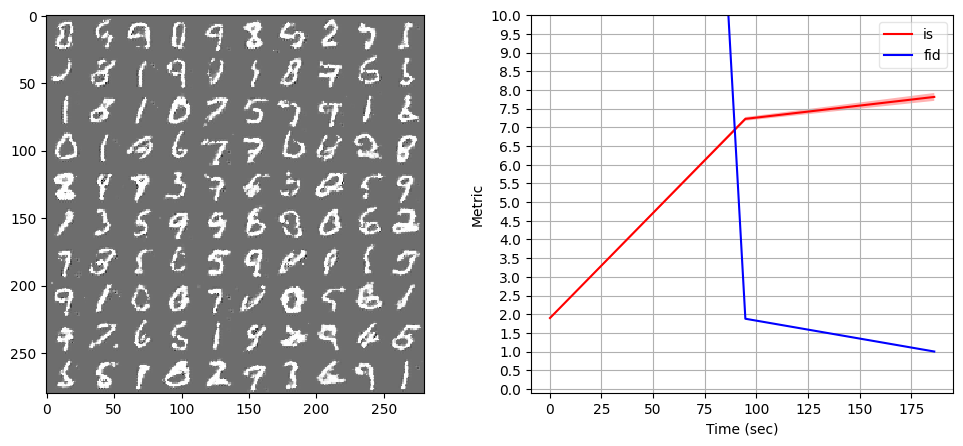

Iter 15000: Mean proba from D(G(z)): 0.5125 +/- 0.0926


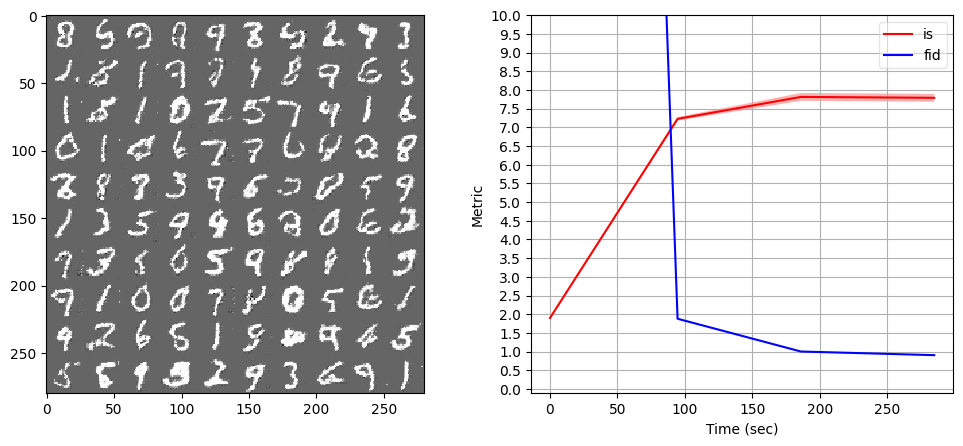

Iter 20000: Mean proba from D(G(z)): 0.4484 +/- 0.0920


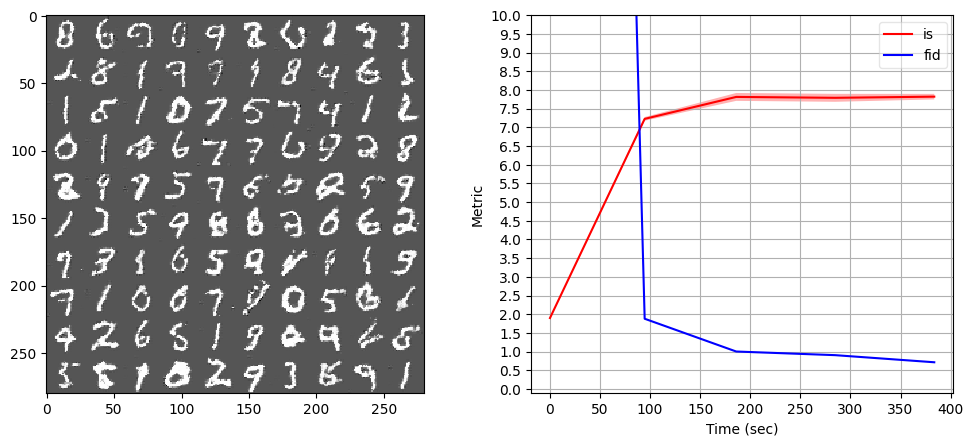

Iter 25000: Mean proba from D(G(z)): 0.5156 +/- 0.0871


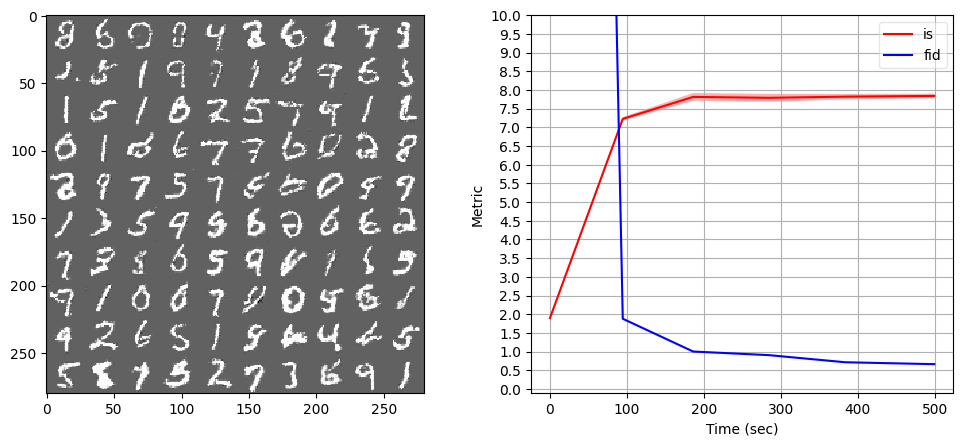

Iter 30000: Mean proba from D(G(z)): 0.5133 +/- 0.0882


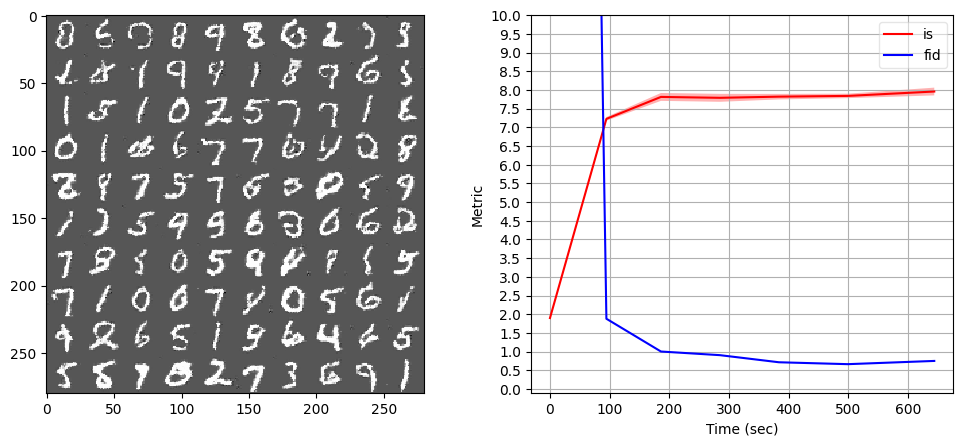

Iter 35000: Mean proba from D(G(z)): 0.4857 +/- 0.0885


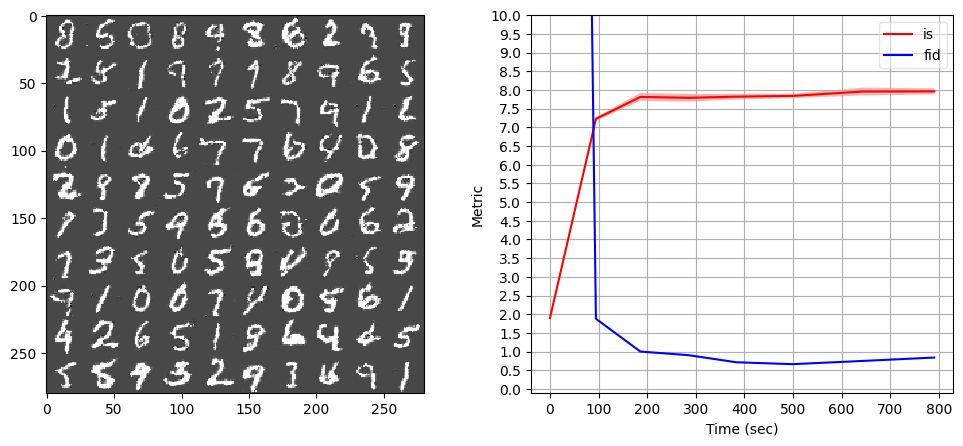

Iter 40000: Mean proba from D(G(z)): 0.4808 +/- 0.0965


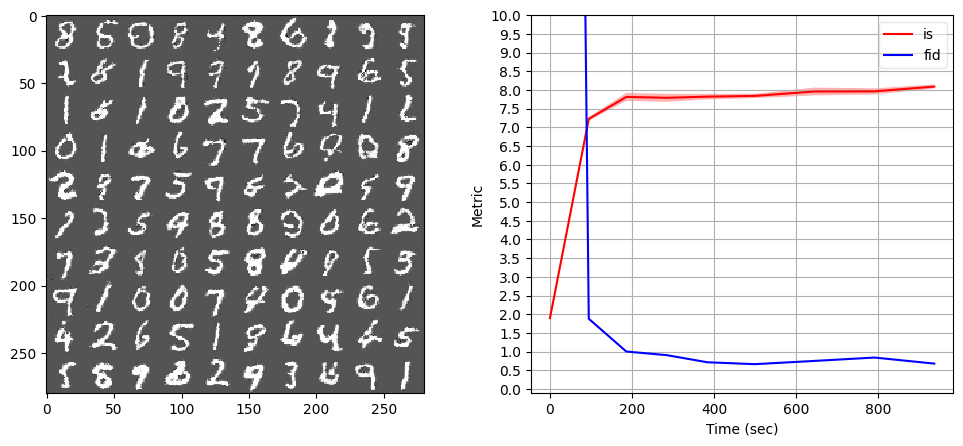

Iter 45000: Mean proba from D(G(z)): 0.4663 +/- 0.0856


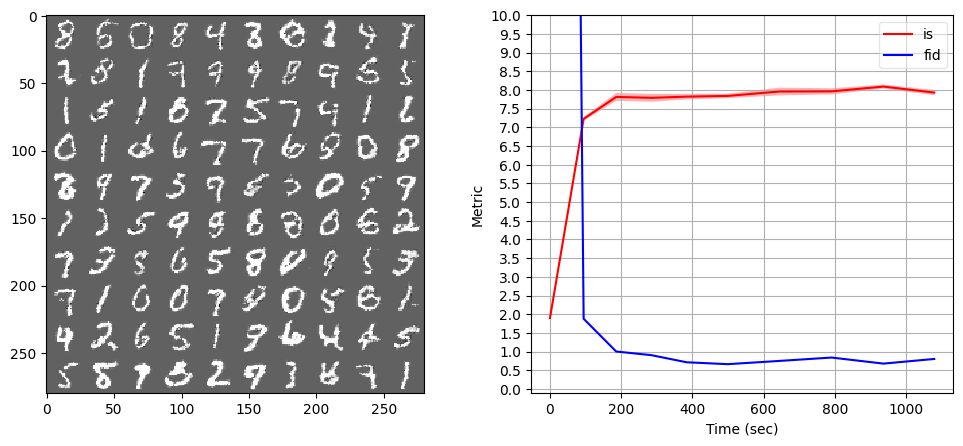

Iter 50000: Mean proba from D(G(z)): 0.4864 +/- 0.0773


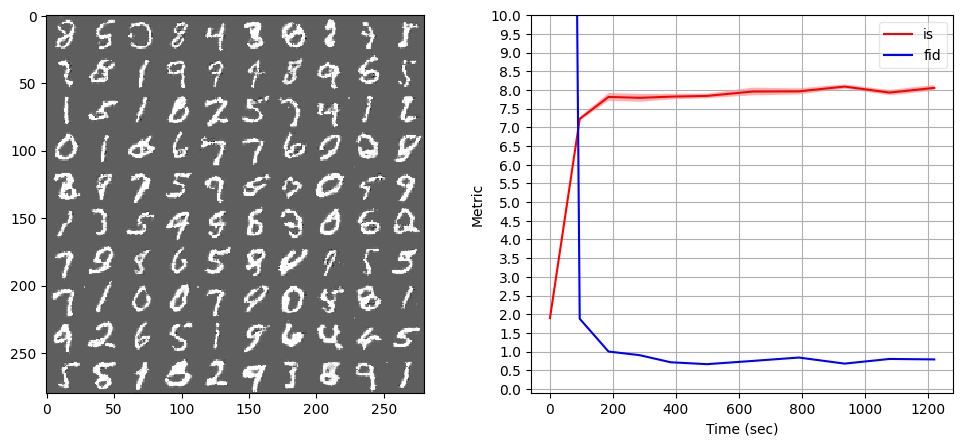

Iter 55000: Mean proba from D(G(z)): 0.5474 +/- 0.0771


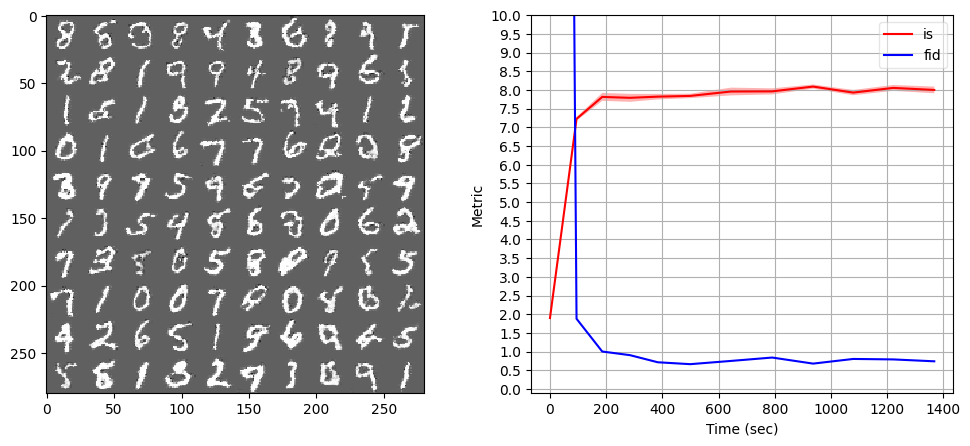

Iter 60000: Mean proba from D(G(z)): 0.5012 +/- 0.0660


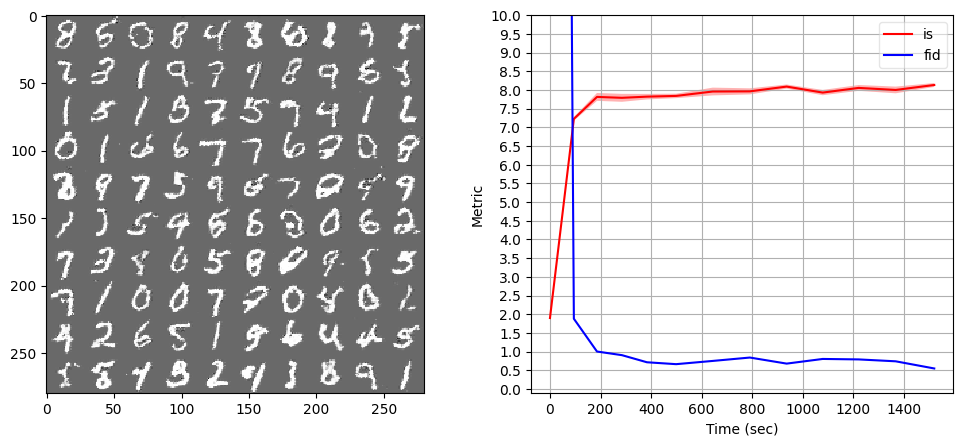

Iter 65000: Mean proba from D(G(z)): 0.5154 +/- 0.0671


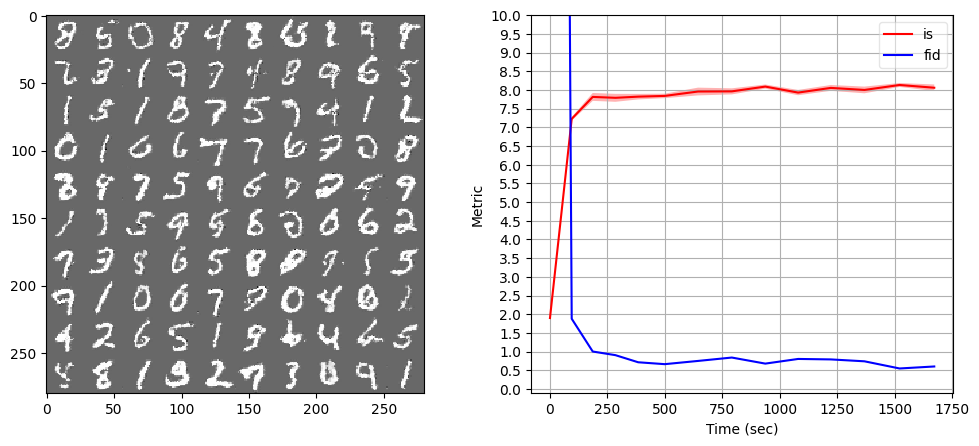

Iter 70000: Mean proba from D(G(z)): 0.5248 +/- 0.0618


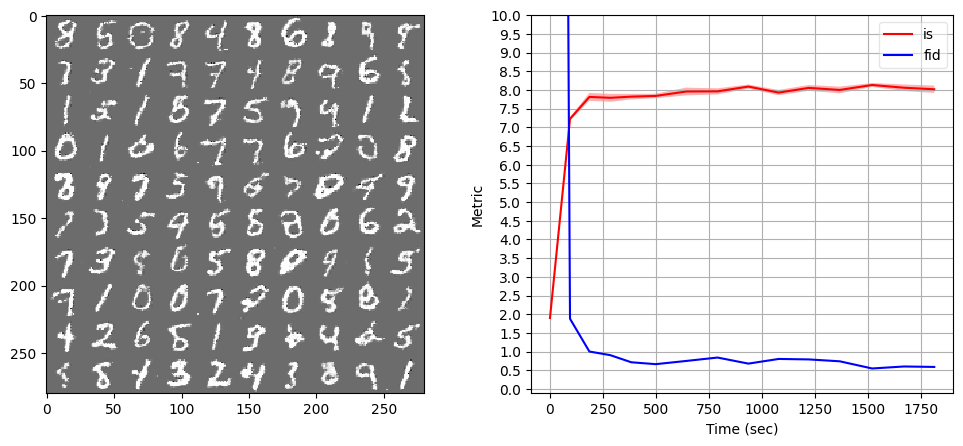

Iter 75000: Mean proba from D(G(z)): 0.4927 +/- 0.0538


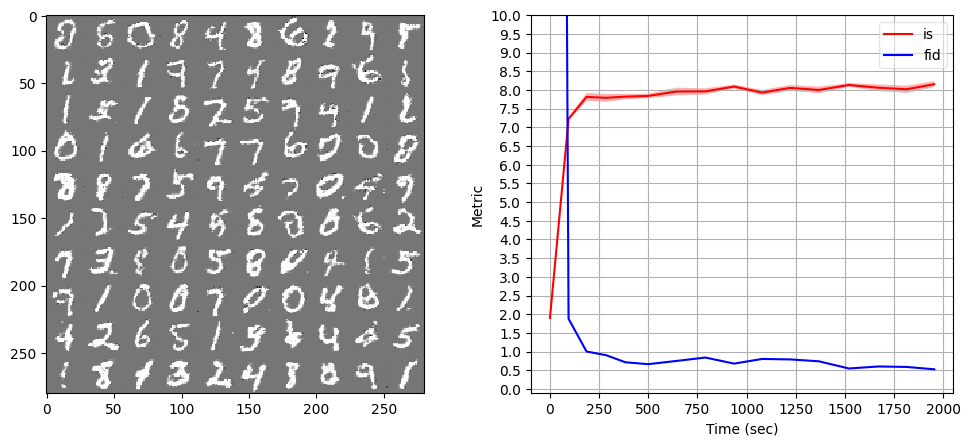

Iter 80000: Mean proba from D(G(z)): 0.5037 +/- 0.0546


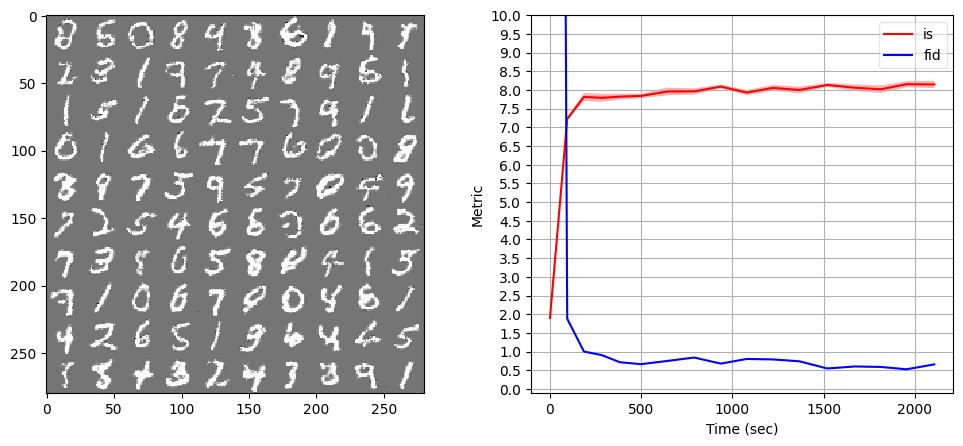

Iter 85000: Mean proba from D(G(z)): 0.4977 +/- 0.0629


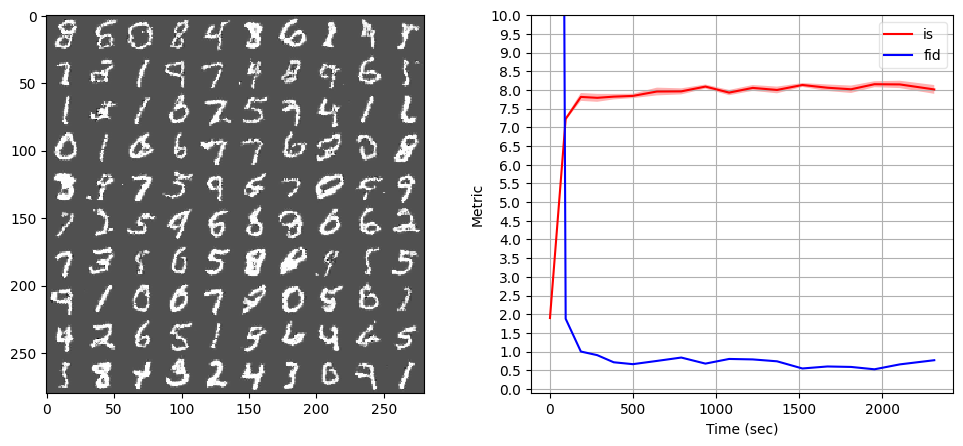

Iter 90000: Mean proba from D(G(z)): 0.4935 +/- 0.0455


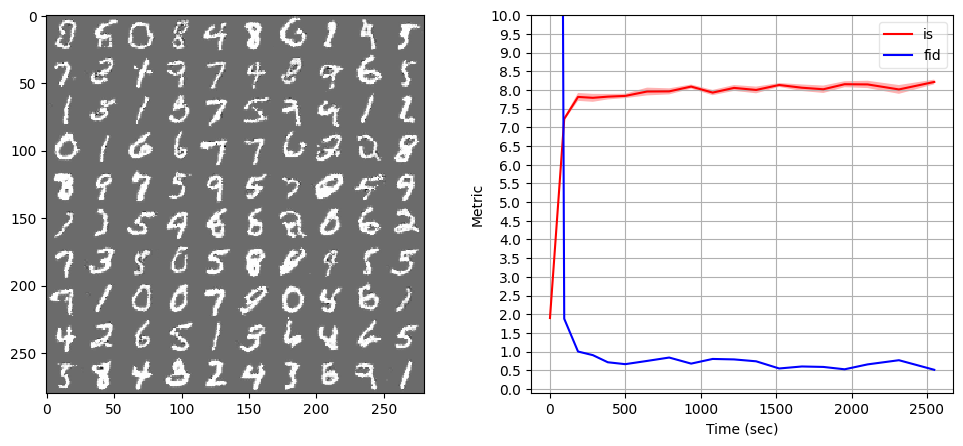

Iter 95000: Mean proba from D(G(z)): 0.4849 +/- 0.0567


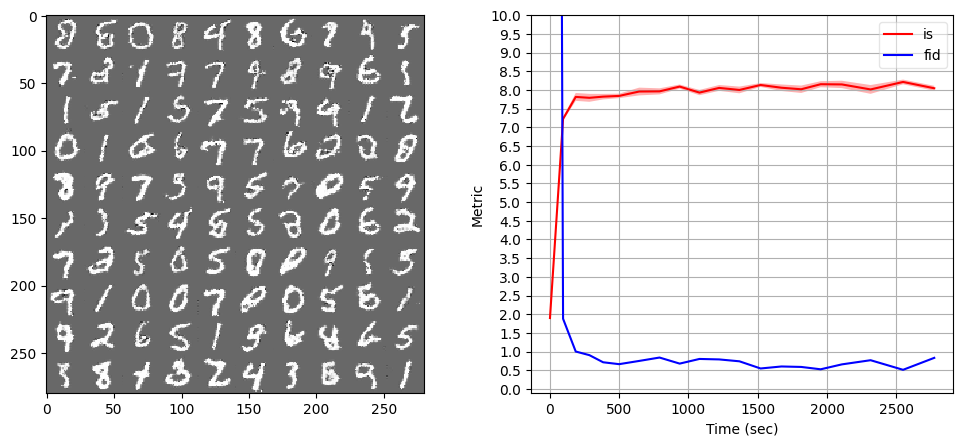

Iter 99999: Mean proba from D(G(z)): 0.4787 +/- 0.0450


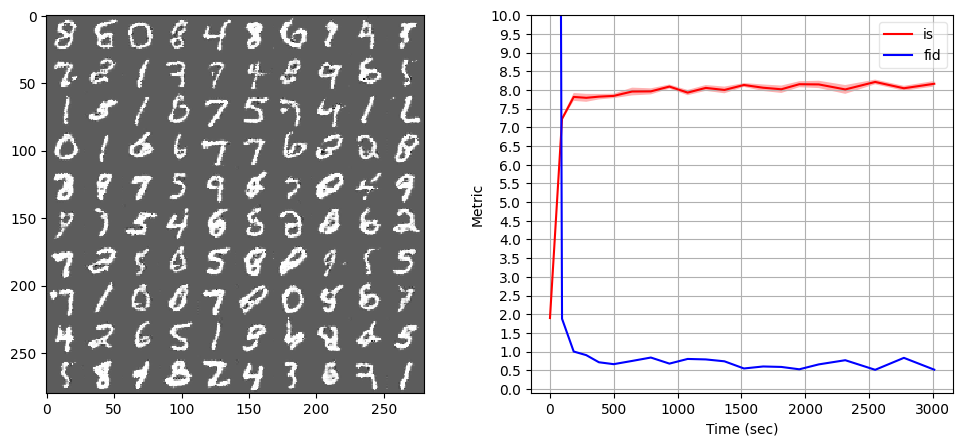

In [23]:
for k in range(1,1+1):
  exp_key = f"iter{args['iterations']}_bs{args['batch_size']}_lrD{args['lrD']}" + \
            f"_lrG{args['lrG']}_beta1{args['beta1']}_lookahead{args['lookahead']}" + \
            f"_lak{args['lookahead_k']}" + \
            f"_extragrad{args['extragrad']}_ee{args['eval_every']}"
  out_dir = f"/home/mila/t/tianyu.zhang/GAN_LOLA/drive/My Drive/results/final/{exp_key}/{k}/"

  shutil.rmtree(out_dir, ignore_errors=True)
  if not os.path.exists(out_dir):
    os.makedirs(out_dir)

  with open(os.path.join(out_dir, 'args.json'), 'w') as fs:
    json.dump(args, fs)

  dataset = load_mnist(_data_root='datasets', binarized=False)

  plot_func = get_plot_func(out_dir=out_dir, 
                            img_size=dataset[0][0].size(),
                            num_samples_eval=10000)

  G = GeneratorCNN28(noise_dim=_NOISE_DIM, h_filters=_H_FILTERS, out_tanh=True)
  D = DiscriminatorCNN28(h_filters=_H_FILTERS, spectral_norm=False, img_size=28)

  train(G, D, dataset, 
        iterations=args['iterations'], 
        batch_size=args['batch_size'], 
        lookahead=args['lookahead'],
        lookahead_k=args['lookahead_k'],
        eval_avg=args['eval_avg'],
        lrD=args['lrD'], 
        lrG=args['lrG'], 
        beta1=args['beta1'], 
        extragrad=args['extragrad'],
        eval_every=args['eval_every'], 
        n_workers=args['n_workers'], 
        device=torch.device(args['device']), 
        grad_max_norm=args['grad_max_norm'], 
        plot_func=plot_func,
        out_dir=out_dir)

In [1]:
import torch
import numpy as np
from torch.nn import Module
import torch.nn.functional as F

class Net(Module):
    def __init__(self, h, w):
        super(Net, self).__init__()
        self.c1 = torch.nn.Conv2d(1, 32, 3, 1, 1)
        self.f2 = torch.nn.Linear(32 * h * w, 5)

    def forward(self, x):
        x = self.c1(x)
        x = x.view(x.size(0), -1)
        x = self.f2(x)
        return x

def haha(a, b, c, d):
    p = [a.view(32, 1, 3, 3), b, c.view(5, 32 * 12 * 12), d]
    x = torch.randn(size=[8, 1, 12, 12], dtype=torch.float32)
    y = torch.randint(0, 5, [8])
    x = F.conv2d(x, p[0], p[1], 1, 1)
    x = x.view(x.size(0), -1)
    x = F.linear(x, p[2], p[3])
    loss = F.cross_entropy(x, y)
    return loss


if __name__ == '__main__':
    net = Net(12, 12)

    h = torch.autograd.functional.hessian(haha, tuple([_.view(-1) for _ in net.parameters()]))